In [1]:
import numpy as np
import os
import pandas as pd
import warnings
from scipy.stats import gaussian_kde
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
from astropy import units
from importlib import reload
import pickle

import matplotlib as mpl
mpl.use('Agg')

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':32})

% matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import keras

Using Theano backend.


In [3]:
wdir = '/home/mho1/scratch/halo_cnn'


imdir = '/home/mho1/halo_cnn/paper_images'

In [4]:
import tools.matt_tools as matt

reload(matt)

<module 'tools.matt_tools' from '/home/mho1/halo_cnn/notebooks/tools/matt_tools.py'>

# Notes

 * Virial scaling: http://adsabs.harvard.edu/abs/2008ApJ...672..122E
 
 * Coma Mass WL 2007: ~1.88 * 10^15 M_sol/h   [ref: http://adsabs.harvard.edu/abs/2007ApJ...671.1466K]
 * Coma Mass Dyn 1987: ~0.95 * 10^15 M_sol/h [http://adsabs.harvard.edu/abs/1986AJ.....92.1248T]
 
### Virgo (Photometric) 
 * Virgo Survey: http://astrowww.phys.uvic.ca/~lff/NGVS/The_Data.html
 * Virgo Data: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/

# Tools

In [5]:
obj_dtype = [('z','f'),('ra','f'),('dec','f'), # raw
             ('vlos','f'), ('Rproj','f')]      # derived

In [6]:
# ~~~~~ PLOTTING ~~~~~
def plot_hist(data, n=30, label=None):
    vals, bin_edg = np.histogram(data, bins=n, density=True)
    
    plt.plot([(bin_edg[i]+bin_edg[i+1])/2. for i in range(len(bin_edg)-1)],
             vals,
             label = label
            )
    
    return vals, bin_edg

# ~~~~~ COSMOLOGY ~~~~~
def Rproj_from_radec(gals, cl):
    pos_cl = SkyCoord(ra=cl['ra']*units.deg, dec=cl['dec']*units.deg)
    pos_gal = SkyCoord(ra=gals['ra']*units.deg, dec=gals['dec']*units.deg)
    
    gal_Rproj = cosmo.kpc_proper_per_arcmin(cl['z']).value * \
                pos_gal.separation(pos_cl).arcmin / cosmo.h # [kpc/h]
    gal_Rproj /= 1000. # [Mpc/h]
    
    gals['Rproj'] = gal_Rproj
    
    return gals

def vlos_from_z(gals,cl):
    c = 299792.458  # [km/s]
    gal_vlos = c*(gals['z'] - cl['z'])/(1.0+cl['z']) # [km/s]
    
    gals['vlos'] = gal_vlos

    return gals

def add_vlos_Rproj(gals,cl):
    
    gals = vlos_from_z(gals,cl)
    gals = Rproj_from_radec(gals,cl)
    
    return gals

def logMvir(sigv):
    # ref: http://adsabs.harvard.edu/abs/2008ApJ...672..122E
    
    sigv_15 = 1082.9 # km/s
    alpha = 0.3361
    
    return np.log10((sigv/sigv_15)**(1/alpha) * 10**15)

# ~~~~ PREPROCESSING ~~~~~

def cylinder_cut(gals, cl, 
                 aperture=1.6, # Mpc/h
                 vcut = 2500. # [km/s]
                ):
    
    # Check for derived quantities
    if (np.sum(gals['vlos']==0)!=0) | (np.sum(gals['Rproj']==0)!=0):
        warnings.warn('Zero vlos, Rproj. Check if derived quantities have been updated.')
    
    members =(np.abs(gals['vlos']) < vcut) & (gals['Rproj'] < aperture)
    
    return gals[members]

def kde_1d( gals,
            shape = (48,1), bwidth = 0.25,
            vcut = 2500. # [km/s]
          ):
    
    # Check for derived quantities
    if (np.sum(gals['vlos']==0)!=0):
        warnings.warn('Zero vlos. Check if derived quantities have been updated.')
    
    v_pos = np.linspace(-vcut,vcut, shape[0]+1)
    sample = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    
    kde = gaussian_kde(gals['vlos'], bwidth)
    
    kdeval = kde(sample).T
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

def kde_2d( gals,
            shape=(48,48), bwidth=0.25,
            vcut = 2500., # [km/s]
            aperture = 1.6, # [Mpc/h]
          ):
    
    v_pos = np.linspace(-vcut, vcut, shape[0] + 1)
    a_pos = np.linspace(0, aperture, shape[1] + 1)
    v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

    mesh = np.meshgrid(a_pos,v_pos)
    mesh = np.flip(mesh,0)
    sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()])
    
    
    kde = gaussian_kde((gals['vlos'],gals['Rproj']), bwidth)
    
    kdeval = np.reshape(kde(sample).T, mesh[0].shape)
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

def kde_Rproj( gals,
               shape = (48,1), bwidth = 0.25,
               aperture = 1.6, # [Mpc/h]
             ):
    
    # Check for derived quantities
    if (np.sum(gals['Rproj']==0)!=0):
        warnings.warn('Zero Rproj. Check if derived quantities have been updated.')
    
    R_pos = np.linspace(0,aperture, shape[0]+1)
    sample = [np.mean(R_pos[[i,i+1]]) for i in range(len(R_pos)-1)]
    
    kde = gaussian_kde(gals['Rproj'], bwidth)
    
    kdeval = kde(sample).T
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

# Load Models

## Point Estimation

In [7]:
# from paper
# model_1d_num = 152
# model_2d_num = 67

# expanded range
# model_1d_num = 154
# model_2d_num =  74

# train z=0.000
model_1d_num = 158
model_2d_num =  77

In [8]:
# Load keras models

model_1d = [None]*10
model_2d = [None]*10

for i in range(10):
    print('fold:',i)
    
    model_1d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                                           str(model_1d_num)+'/models/fold_'+str(i)+'.h5')
    model_2d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                                           str(model_2d_num)+'/models/fold_'+str(i)+'.h5')

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


In [9]:
# Load params

par_1d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                 str(model_1d_num)+'/halo_cnn1d_r_' + \
                 str(model_1d_num) + '.npy',
                 encoding='latin1').item()['params']

par_2d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                 str(model_2d_num)+'/halo_cnn2d_r_' + \
                 str(model_2d_num) + '.npy',
                 encoding='latin1').item()['params']

def logM_from_y1d(y):
    y = (y+1)/2.
    return (par_1d['logmass_max'] - par_1d['logmass_min'])*y + par_1d['logmass_min']
def logM_from_y2d(y):
    y = (y+1)/2.
    return (par_2d['logmass_max'] - par_2d['logmass_min'])*y + par_2d['logmass_min']

## Posterior Estimation

In [10]:
# model_1dP_num = 1
# model_2dP_num = 7

# train z=0.000
model_1dP_num = 4
model_2dP_num = 10

In [11]:
# Load keras models

model_1dP = [None]*10
model_2dP = [None]*10

for i in range(10):
    print('fold:',i)
    
    model_1dP[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_rP/halo_cnn1d_rP_' + \
                                            str(model_1dP_num)+'/models/fold_'+str(i)+'.h5')
    model_2dP[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_rP/halo_cnn2d_rP_' + \
                                            str(model_2dP_num)+'/models/fold_'+str(i)+'.h5')

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


In [12]:
# Load params

par_1dP = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_rP/halo_cnn1d_rP_' + \
                  str(model_1dP_num)+'/halo_cnn1d_rP_' + \
                  str(model_1dP_num) + '.npy',
                  encoding='latin1').item()['params']

par_2dP = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_rP/halo_cnn2d_rP_' + \
                  str(model_2dP_num)+'/halo_cnn2d_rP_' + \
                  str(model_2dP_num) + '.npy',
                  encoding='latin1').item()['params']

def logM_from_y1dP(y):
    return (par_1dP['logmass_max'] - par_1dP['logmass_min'])*y + par_1dP['logmass_min']
def logM_from_y2dP(y):
    return (par_2dP['logmass_max'] - par_2dP['logmass_min'])*y + par_2dP['logmass_min']

bin_edges_1dP = np.linspace(0, 1, par_1dP['nbins']+1)
bin_centers_1dP = np.array([np.mean((bin_edges_1dP[i],bin_edges_1dP[i+1])) for i in range(par_1dP['nbins'])])
bin_centers_1dP = logM_from_y1dP(bin_centers_1dP)

bin_edges_2dP = np.linspace(0, 1, par_2dP['nbins']+1)
bin_centers_2dP = np.array([np.mean((bin_edges_2dP[i],bin_edges_2dP[i+1])) for i in range(par_2dP['nbins'])])
bin_centers_2dP = logM_from_y2dP(bin_centers_2dP)

## Model parameters

In [13]:
shape_1d = (*par_1d['shape'],1)
shape_2d = par_2d['shape']

bandwidth=0.25

# medium
aperture = 1.6 # [Mpc/h]
vcut = 2500. # [km/s]

# large
# aperture = 2.3 #Mpc/h
# vcut = 3785. #km/s

## 1DP and 2DP comparison

In [30]:
z = 0.000


data_path = os.path.join(wdir, 'data_processed', 'halo_cnn1d_r')

mass_preds = {}


print(z)
with open(os.path.join(data_path, 'halo_cnn1d_r_z=' +'%.3f'%z+ '.p'), 'rb') as f:
    data_proc = pickle.load(f)['data']

in_dat = data_proc['pdf'][data_proc['in_test']==1]
in_dat = np.reshape(in_dat, (*(in_dat.shape),1))

pred_temp = logM_from_y1d(model_1d[0].predict(in_dat)).flatten()
for i in range(1,10):
    pred_temp += logM_from_y1d(model_1d[i].predict(in_dat)).flatten()

pred_temp/=10.


pred_1dp = []

for i in range(0,10):
    pred_1dp.append(np.dot(model_1dP[i].predict(in_dat), bin_centers_1dP))

0.0


In [35]:
preds_1d = pred_temp
preds_1dp = np.mean(pred_1dp,axis=0)

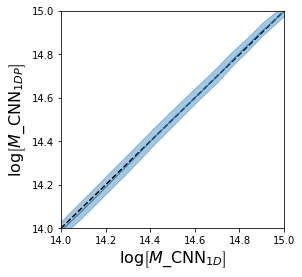

In [151]:
f, ax = plt.subplots(figsize=(4,4))

plt.plot(np.arange(14,15.1,0.1),np.arange(14,15.1,0.1),'k--')
matt.binnedplot(preds_1d,preds_1dp,n=25, percentiles=[34], 
                median=True, ax=ax)

plt.xlabel(r'$\log\left[M\_\mathrm{CNN}_{1D}\right]$', fontsize=16)
plt.ylabel(r'$\log\left[M\_\mathrm{CNN}_{1DP}\right]$', fontsize=16)
plt.xlim(14,15)
plt.ylim(14,15)


f.savefig(os.path.join(imdir, '1D_1DP_compare.png'),bbox_inches='tight',dpi=400)

# Coma

## Mass Estimates

In [14]:
import colossus
from colossus.cosmology import cosmology
cosmology.setCosmology('planck15')

from colossus.halo import concentration

 * $M_\mathrm{virial}\left(\leq2.7\ h^{-1}Mpc\right) = (0.95\pm0.14)*10^{15}\ h^{-1}M_\odot$ [(1986)](http://adsabs.harvard.edu/abs/1986AJ.....92.1248T)
 
 * $M_\mathrm{X-ray}\left(\leq 2.5\ h^{-1}Mpc\right) = (0.93\pm0.12)*10^{15}\ h^{-1}M_\odot$  [(1989)](http://adsabs.harvard.edu/abs/1989ApJ...337...21H)
 
 * $M_\mathrm{caustic}\left(\leq 5.5\ h^{-1} Mpc\right) = (1.44\pm0.29)*10^{15}\ h^{-1}M_\odot$ [(1999)](http://adsabs.harvard.edu/abs/1999ApJ...517L..23G)
 
 * $M_\mathrm{Jeans, sigv, kurt}\left(\leq2.03\ h^{-1}Mpc\right) = (0.98\pm0.35)*10^{15}\ h^{-1}M_\odot$ [(2003)](http://adsabs.harvard.edu/abs/2003MNRAS.343..401L)
 
 * $M_{\mathrm{WL}}\left(\leq1.99^{+0.21}_{-0.22}\ h^{-1}Mpc\right) = 1.88^{+0.65}_{-0.56}*10^{15}\ h^{-1}M_\odot$ [(2007)](http://adsabs.harvard.edu/abs/2007ApJ...671.1466K)
 
 * $M_{\mathrm{WL}}\left(\leq1.2^{+0.42}_{-0.20}\ h^{-1}Mpc\right) = 0.53^{+0.45}_{-0.22}*10^{15}\ h^{-1}M_\odot$ [(2009)](http://adsabs.harvard.edu/abs/2009A%26A...498L..33G)
 
 * $M_\mathrm{kinematic}\left(\leq1.64\ h^{-1}Mpc\right) = (0.62\pm 0.16)*10^{15}\ h^{-1}M_\odot$ [(2014)](http://adsabs.harvard.edu/abs/2014MNRAS.442.1887F)

In [15]:
coma_masses = {
    'vir (1986)' : [2.7, 0.95, (-0.14,0.14)],
    'xray (1989)' : [2.5, 0.93, (-0.12,0.12)],
    'caustic (1999)' : [5.5, 1.44, (-0.29,0.29)],
    'Jeans (2003)' : [2.03, 0.98, (-0.35,0.35)],
    'WL (2007)' : [1.99, 1.88, (-0.65,0.56)],
    'WL (2009)' : [1.2, 0.53, (-0.22,0.45)],
    'infall (2014)' : [1.64, 0.62, (-0.16,0.16)]
}

In [16]:
def m(x):
    return np.log(1+x)-x/(1.+x)

def M_H(R_H, r_s, rho_s):
    return 4*np.pi*r_s**3*rho_s*m(R_H/r_s)

def logM_H(R_H, r_s, rho_s):
    return np.log10(M_H(R_H, r_s, rho_s))


In [17]:
from scipy.optimize import curve_fit

beta,_= curve_fit(logM_H, 
                  [coma_masses[key][0]*1000 for key in coma_masses.keys()],
                  [np.log10(coma_masses[key][1]*10**15) for key in coma_masses.keys()],
                  sigma = [(np.log10((coma_masses[key][1]+coma_masses[key][2][1])*10**15)-\
                           np.log10(coma_masses[key][1]*10**15)) for key in coma_masses.keys()],
                  p0=[10000,cosmology.getCurrent().rho_c(0)])

beta,_

(array([1.85289978e+02, 7.09256181e+06]),
 array([[ 1.10420937e+05, -1.06015168e+10],
        [-1.06015168e+10,  1.01838304e+15]]))

In [18]:
p_c = cosmology.getCurrent().rho_c(z=0)*(1000.)**3

def M_200c(R_200c):
    return (4*np.pi/3.)*200*p_c*R_200c**3

def R_200c(M_200c):
    return (3*M_200c/(4*np.pi*200*p_c))**(1/3.)

R_200c(10**15)

1.6263696730469728

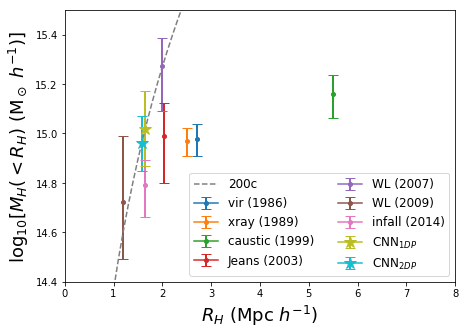

In [19]:
f = plt.figure(figsize=(7,5))

for key in coma_masses.keys():
    plt.errorbar(x=coma_masses[key][0], 
                 y=np.log10(coma_masses[key][1]*10**15),
                 yerr=np.abs(np.log10((coma_masses[key][1]+np.array([coma_masses[key][2]]).reshape((2,1)))*10**15)-\
                      np.log10(coma_masses[key][1]*10**15)),
                 label=key, capsize=5,elinewidth=2,markersize=8,
                 marker='.')

# plt.plot(np.arange(1.3,5.6,0.1), np.log10(M_H(np.arange(1.3,5.6,0.1)*1000,*beta)),
#          '--',label='fit')
plt.plot(np.arange(0,5.6,0.1), np.log10(M_200c(np.arange(0,5.6,0.1))),
         '--',label='200c')

plt.errorbar(x=R_200c(10**15.02), y=np.log10(10**15.02),yerr=0.15,
             marker='*',label='CNN$_{1DP}$', 
             elinewidth=2,markersize=12,capsize=5)
plt.errorbar(x=R_200c(10**14.96), y=np.log10(10**14.96),yerr=0.11,
             marker='*',label='CNN$_{2DP}$', 
             elinewidth=2,markersize=12,capsize=5)
plt.xlim(0,8)
plt.ylim(14.4,15.5)
plt.xlabel('$R_H$ (Mpc $h^{-1}$)', fontsize=18)
plt.ylabel(r'$\log_{10}[M_H\left(<R_H\right)$ (M$_\odot$ $h^{-1})]$', fontsize=18)
plt.legend(ncol=2,loc=4, fontsize=12)

# f.savefig(os.path.join(imdir, 'coma_masses.png'),bbox_inches='tight',dpi=400)

In [20]:
def M_200c_from_M(M, R, M_200ctrue):
    c = concentration.concentration(M=M_200ctrue, z=0.0, mdef='200c', model='diemer15')
    R_200ctrue = R_200c(M_200ctrue)
    
    r_s = R_200ctrue/c
    
    return M*m(R/r_s)/m(c)

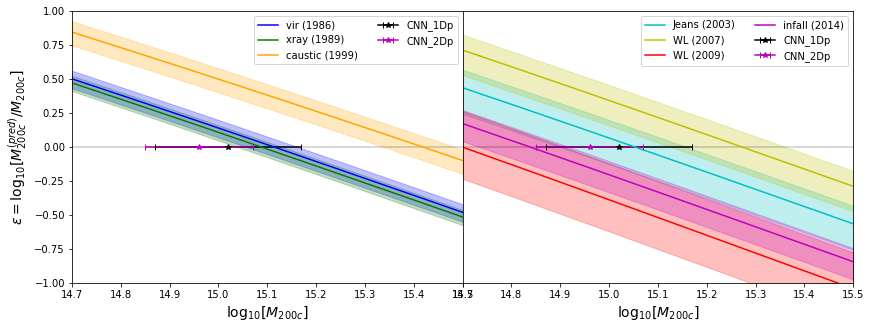

In [21]:
M_true_list = 10**np.arange(14.7,15.5,0.001)

out = np.zeros(shape=(len(coma_masses.keys()),len(M_true_list),3))

for i, key in np.ndenumerate(list(coma_masses.keys())):
    i=i[0]
    for j, M_true in np.ndenumerate(list(M_true_list)):
        j=j[0]
        out[i,j,0] = M_200c_from_M(M=coma_masses[key][1]*10**15,
                                   R=coma_masses[key][0],
                                   M_200ctrue=M_true)
        out[i,j,1] = M_200c_from_M(M=(coma_masses[key][1]+coma_masses[key][2][0])*10**15,
                                   R=coma_masses[key][0],
                                   M_200ctrue=M_true)
        out[i,j,2] = M_200c_from_M(M=(coma_masses[key][1]+coma_masses[key][2][1])*10**15,
                                   R=coma_masses[key][0],
                                   M_200ctrue=M_true)
        
f = plt.figure(figsize=(14,5))
gs = mpl.gridspec.GridSpec(1,2,wspace=0)

c = ['b','g','orange','c','y','r','m']

ax = f.add_subplot(gs[0,0])
ax.plot(np.log10(M_true_list),[0]*len(M_true_list),'-',c='k', alpha=0.2)
for i, key in np.ndenumerate(list(coma_masses.keys())[:3]):
    i=i[0]
    ax.plot(np.log10(M_true_list), np.log10(out[i,:,0]/M_true_list), label=key, c=c[i])
    ax.fill_between(np.log10(M_true_list), np.log10(out[i,:,1]/M_true_list), np.log10(out[i,:,2]/M_true_list), 
                     alpha=0.25, color=c[i],)

ax.errorbar(x=np.log10(10**15.02), y=0, xerr=0.15,
             marker='*',label='CNN_1Dp', c='k', capsize=3)
ax.errorbar(x=np.log10(10**14.96), y=0, xerr=0.11,
             marker='*',label='CNN_2Dp', c='m', capsize=3)
    
ax.set_xlim(np.log10(M_true_list.min()),np.log10(M_true_list.max()))
ax.set_ylim(-1,1)
ax.set_xlabel('$\log_{10}[M_{200c}]$', fontsize=14)
ax.set_ylabel('$\epsilon=\log_{10}[M_{200c}^{(pred)}/M_{200c}]$', fontsize=14)
ax.legend(ncol=2)

ax = f.add_subplot(gs[0,1])
ax.plot(np.log10(M_true_list),[0]*len(M_true_list),'-',c='k', alpha=0.2)
for i, key in np.ndenumerate(list(coma_masses.keys())[3:]):
    i=i[0]+3
    ax.plot(np.log10(M_true_list), np.log10(out[i,:,0]/M_true_list), label=key, c=c[i])
    ax.fill_between(np.log10(M_true_list), np.log10(out[i,:,1]/M_true_list), np.log10(out[i,:,2]/M_true_list), 
                     alpha=0.25, color=c[i])
    
ax.errorbar(x=np.log10(10**15.02), y=0, xerr=0.15,
             marker='*',label='CNN_1Dp', c='k', capsize=3)
ax.errorbar(x=np.log10(10**14.96), y=0, xerr=0.11,
             marker='*',label='CNN_2Dp', c='m', capsize=3)
    
ax.set_xlim(np.log10(M_true_list.min()),np.log10(M_true_list.max()))
ax.set_ylim(-1,1)
ax.set_xlabel('$\log_{10}[M_{200c}]$', fontsize=14)
ax.set_yticks([])
ax.legend(ncol=2)

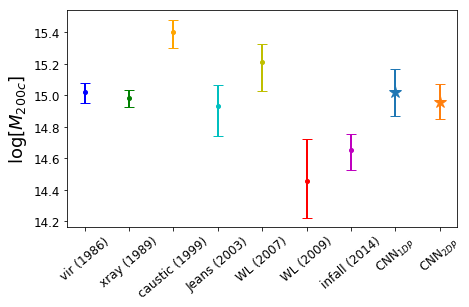

In [22]:
f = plt.figure(figsize=(7,4))

for i, key in np.ndenumerate(list(coma_masses.keys())):
    i=i[0]
    sol = np.argmin(out[i,:,0] - M_true_list)
    
    plt.errorbar(x=i, y=np.log10(out[i,sol,0]), 
                 yerr = np.array(([-np.log10(out[i,sol,1]/out[i,sol,0])], [np.log10(out[i,sol,2]/out[i,sol,0])])),
                 label=key, capsize=5,elinewidth=2,markersize=8,
                 marker='.', color=c[i])

plt.errorbar(y=15.02, x=i+1, yerr=0.15,
             marker='*',label='CNN_1Dp',
             elinewidth=2,markersize=12,capsize=5)
plt.errorbar(y=14.96, x=i+2, yerr=0.11,
             marker='*',label='CNN_2Dp',
             elinewidth=2,markersize=12,capsize=5)


plt.xticks(list(np.arange(len(coma_masses)+2)), 
           list(coma_masses.keys()) + ['CNN$_{1DP}$','CNN$_{2DP}$'],
           rotation=40, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r'$\log\left[M_{200c}\right]$', fontsize=18)

f.savefig(os.path.join(imdir, 'coma_m200c.png'),bbox_inches='tight',dpi=400)

In [73]:
p_c = cosmology.getCurrent().rho_c(z=0)*(1000.)**3

def rho_bar(M,R):
    return M/(4*np.pi/3.*R**3)

Text(0,0.5,'$\\bar\\rho-200\\rho_c$')

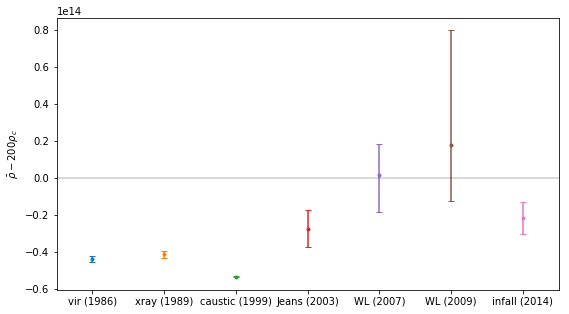

In [77]:
f,ax = plt.subplots(figsize=(9,5))

plt.plot(np.arange(9)-1,np.arange(9)-1,'k',alpha=0.2)
for i, key in np.ndenumerate(list(coma_masses.keys())):
    i=i[0]
    
    plt.errorbar(x=i, y=rho_bar(coma_masses[key][1]*10**15,coma_masses[key][0])-200*p_c,
                 yerr = np.abs((rho_bar((coma_masses[key][1]+np.array([coma_masses[key][2]]).reshape((2,1)))*10**15,coma_masses[key][0])-200*p_c) - \
                         (rho_bar(coma_masses[key][1]*10**15,coma_masses[key][0])-200*p_c)),
                 marker='.',capsize=3)
plt.xlim(-0.5,6.5)
plt.xticks(list(np.arange(len(coma_masses))), coma_masses.keys())

plt.ylabel(r'$\bar\rho-200\rho_c$')

In [15]:
np.log10(rho_bar(coma_masses[key][1]*10**15,coma_masses[key][0])-p_c)

13.522165432679468

## Data

In [23]:
dat_cl = pd.read_csv(os.path.join(wdir,'data_obs','GAMAspec_coma','coma_cluster.csv'))

print(dat_cl.columns.values)

dat_cl=dat_cl.rename(index=str,columns={'ra':'RA','dec':'DEC','z':'Z'}) # same format as RedMapper

dat_cl.head()

['ra' 'dec' 'specobjid' 'z']


,RA,DEC,specobjid,Z
0,193.97707,27.734459,7295860639766605824,2.888782
1,193.99803,28.486930,2264256514497734656,0.142809
2,193.99821,28.622316,7296075319411929088,0.511981
3,193.99900,27.955075,2522132678577252352,0.027008
4,194.09395,28.796575,7296086314528206848,0.530268


In [24]:
# Cluster center

cl = np.zeros(shape=(1,),dtype=obj_dtype)

cl['z'] = 0.0231 # wikipedia
cl['ra'] = np.mean(dat_cl['RA'])
cl['dec'] = np.mean(dat_cl['DEC'])

print('z_0:', cl['z'])
print('ra_0:', cl['ra'])
print('dec_0:', cl['dec'])

z_0: [0.0231]
ra_0: [194.87663]
dec_0: [27.924927]


In [25]:
# Galaxy sample

gals = np.zeros(shape=(len(dat_cl),), dtype=obj_dtype)

gals['z'] = dat_cl['Z']
gals['ra'] = dat_cl['RA']
gals['dec'] = dat_cl['DEC']

gals = add_vlos_Rproj(gals, cl)

gals = cylinder_cut(gals, cl, aperture=aperture, vcut=vcut)

Text(0,0.5,'dec')

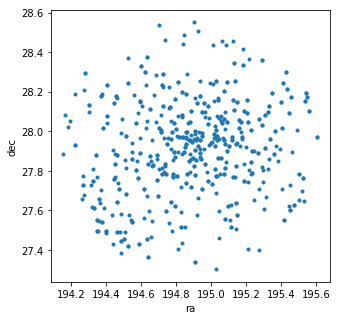

In [26]:
f = plt.figure(figsize=(5,5))

plt.plot(gals['ra'], gals['dec'],'.')

plt.xlabel('ra')
plt.ylabel('dec')

# f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

In [27]:
kdeval_1d = kde_1d(gals, shape=shape_1d, vcut=vcut, bwidth=bandwidth)
kdeval_2d = kde_2d(gals,  shape=shape_2d, aperture=aperture, vcut=vcut, bwidth=bandwidth)
kdeval_Rproj = kde_Rproj(gals,  shape=shape_1d, aperture=aperture, bwidth=bandwidth)

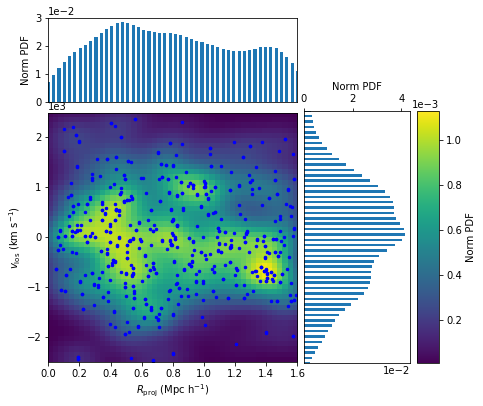

In [28]:

f = plt.figure(figsize=(7,6.35))
gs = mpl.gridspec.GridSpec(2,3, wspace=0.05,hspace=0.05, width_ratios=[2.8,1.2,0.25],height_ratios=[5,15])


# 2D
ax1 = f.add_subplot(gs[1,0])

im =ax1.imshow(kdeval_2d.reshape(48,48), aspect='auto', interpolation='nearest',
               extent=[0, aperture, -vcut, vcut])

ax1.plot(gals['Rproj'], 
         -gals['vlos'],
         'b.', markersize=5)

ax1.set_ylim(-vcut, vcut)

ax1.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))
ax1.set_aspect(aspect=aperture/(2*vcut),adjustable='box', anchor='E')
ax1.set_xlabel('$R_\mathrm{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax1.set_ylabel('$v_\mathrm{los}$ (km s$^{-1}$)', fontsize=10)


# 1D
ax2 = f.add_subplot(gs[1,1])
v_pos = np.linspace(-vcut, vcut, 48)
ax2.barh(v_pos, kdeval_1d.reshape(48), height=50)

ax2.set_ylim(-vcut, vcut)

ax2.set_xlabel('Norm PDF', fontsize=10)
ax2.set_yticks([])

ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')

# Colorbar
ax3 = f.add_subplot(gs[1,2])
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=kdeval_2d.min(), vmax=kdeval_2d.max())

cb = mpl.colorbar.ColorbarBase(label='Norm PDF', ax=ax3, norm=norm, orientation='vertical')
cb.set_label('Norm PDF',fontsize=10)
cb.formatter.set_powerlimits((0, 1))
cb.update_ticks()

# Rproj
ax4 = f.add_subplot(gs[0,0])
R_pos = np.linspace(0, aperture, 48)
ax4.bar(R_pos, kdeval_Rproj.reshape(48), width=0.02)

ax4.set_xlim(0,aperture)

ax4.set_ylabel('Norm PDF', fontsize=10)
ax4.set_xticks([])

ax4.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
# ax4.xaxis.tick_top()
# ax2.xaxis.set_label_position('top')

# f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

## Predict point

FOLD 0 ~~ cnn1d: 15.031668 	cnn2d: 14.903128
FOLD 1 ~~ cnn1d: 15.030928 	cnn2d: 15.060169
FOLD 2 ~~ cnn1d: 14.993503 	cnn2d: 14.974661
FOLD 3 ~~ cnn1d: 15.105907 	cnn2d: 14.967083
FOLD 4 ~~ cnn1d: 15.059788 	cnn2d: 14.969452
FOLD 5 ~~ cnn1d: 15.041889 	cnn2d: 15.009367
FOLD 6 ~~ cnn1d: 15.0523205 	cnn2d: 14.928506
FOLD 7 ~~ cnn1d: 14.976039 	cnn2d: 14.9513
FOLD 8 ~~ cnn1d: 15.051151 	cnn2d: 14.955385
FOLD 9 ~~ cnn1d: 15.041769 	cnn2d: 14.959243

AVG ~~ cnn1d: 15.038495 	cnn2d: 14.96783

STD ~~ cnn1d: 0.03376438 	cnn2d: 0.040664904


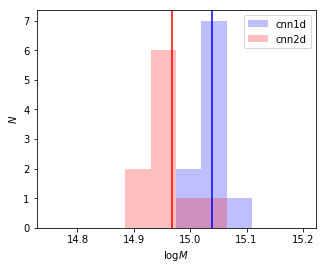

In [16]:
logM_1d = [None]*10
logM_2d = [None]*10

for i in range(10):
    logM_1d[i] = logM_from_y1d(model_1d[i].predict(kdeval_1d)).flatten()[0]
    logM_2d[i] = logM_from_y2d(model_2d[i].predict(kdeval_2d)).flatten()[0]
    
    print('FOLD', i, '~~ cnn1d:', logM_1d[i],'\tcnn2d:', logM_2d[i])
    
print('\nAVG ~~ cnn1d:', np.mean(logM_1d), '\tcnn2d:', np.mean(logM_2d))
print('\nSTD ~~ cnn1d:', np.std(logM_1d), '\tcnn2d:', np.std(logM_2d))


f = plt.figure(figsize=(5,4))

plt.hist(logM_1d, label='cnn1d', color='b', alpha=0.25, range=(14.75,15.2))
plt.hist(logM_2d, label='cnn2d', color='r', alpha=0.25, range=(14.75,15.2))
plt.axvline(np.mean(logM_1d), color='b')
plt.axvline(np.mean(logM_2d), color='r')

plt.xlabel('$\log M$')
plt.ylabel('$N$')
plt.legend()

f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

## Predict posterior

FOLD 0 ~~ cnn1dP: 15.02616 +- 0.14689 	cnn2dP: 14.98814 +- 0.12383
FOLD 1 ~~ cnn1dP: 15.02843 +- 0.15221 	cnn2dP: 14.94721 +- 0.10111
FOLD 2 ~~ cnn1dP: 14.99257 +- 0.15954 	cnn2dP: 14.95244 +- 0.11161
FOLD 3 ~~ cnn1dP: 15.03084 +- 0.14008 	cnn2dP: 14.9689 +- 0.11134
FOLD 4 ~~ cnn1dP: 15.02899 +- 0.147 	cnn2dP: 14.92777 +- 0.1008
FOLD 5 ~~ cnn1dP: 15.02102 +- 0.14411 	cnn2dP: 15.01593 +- 0.11248
FOLD 6 ~~ cnn1dP: 14.96457 +- 0.14298 	cnn2dP: 14.98756 +- 0.11156
FOLD 7 ~~ cnn1dP: 15.02479 +- 0.1462 	cnn2dP: 14.962 +- 0.10947
FOLD 8 ~~ cnn1dP: 15.05714 +- 0.15508 	cnn2dP: 14.94438 +- 0.10988
FOLD 9 ~~ cnn1dP: 14.97772 +- 0.15875 	cnn2dP: 14.93431 +- 0.10236

AVG ~~ cnn1dP: 15.015222584598595 	cnn2dP: 14.96286516363201
STD ~~ cnn1dP: 0.14942072171340148 	cnn2dP: 0.1096378995277583


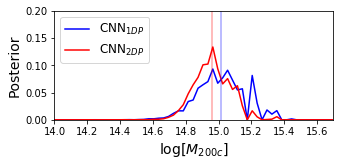

In [33]:
logM_1dP = np.zeros(shape=(par_1dP['nfolds'],par_1dP['nbins']))
logM_2dP = np.zeros(shape=(par_2dP['nfolds'],par_2dP['nbins']))

for i in range(par_1dP['nfolds']):
    logM_1dP[i,:] = model_1dP[i].predict(kdeval_1d)[0]
    logM_2dP[i,:] = model_2dP[i].predict(kdeval_2d)[0]
    
    pred_1dP = np.dot(logM_1dP[i,:], bin_centers_1dP)
    pred_2dP = np.dot(logM_2dP[i,:], bin_centers_2dP)
    std_1dP = np.sqrt(np.dot(logM_1dP[i,:], bin_centers_1dP**2) - pred_1dP**2)
    std_2dP = np.sqrt(np.dot(logM_2dP[i,:], bin_centers_2dP**2) - pred_2dP**2)
    
    print('FOLD', i, '~~ cnn1dP:', round(pred_1dP,5),'+-',round(std_1dP,5),
          '\tcnn2dP:', round(pred_2dP,5),'+-',round(std_2dP,5),)
    
print('\nAVG ~~ cnn1dP:', np.dot(np.mean(logM_1dP, axis=0),bin_centers_1dP), 
      '\tcnn2dP:', np.dot(np.mean(logM_2dP, axis=0),bin_centers_2dP))
print('STD ~~ cnn1dP:', np.sqrt(np.sum(np.dot(logM_1dP,bin_centers_1dP**2) - np.dot(logM_1dP,bin_centers_1dP)**2))/np.sqrt(par_1dP['nfolds'])
      , '\tcnn2dP:', np.sqrt(np.sum(np.dot(logM_2dP,bin_centers_2dP**2) - np.dot(logM_2dP,bin_centers_2dP)**2))/np.sqrt(par_2dP['nfolds']))

f = plt.figure(figsize=(5,2))

plt.plot(bin_centers_1dP, np.mean(logM_1dP,axis=0), label='CNN$_{1DP}$', color='b', alpha=1)#, width=2.5/par_1dP['nbins'])
plt.plot(bin_centers_2dP, np.mean(logM_2dP,axis=0), label='CNN$_{2DP}$', color='r', alpha=1)#, width=2.5/par_2dP['nbins'])
plt.axvline(np.dot(np.mean(logM_1dP, axis=0),bin_centers_1dP), color='b', alpha=0.35)
plt.axvline(np.dot(np.mean(logM_2dP, axis=0),bin_centers_2dP), color='r', alpha=0.35)

plt.xlabel('$\log[M_{200c}]$', fontsize=14)
plt.ylabel('Posterior', fontsize=14)

plt.xlim(14,15.7)
plt.ylim(0,0.2)
plt.legend(fontsize=12, loc=2)

f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=400)

## GAMAspec_SDSS Clusters

In [10]:
cl_files = os.listdir(os.path.join(wdir,'data_obs','GAMAspec_SDSSclu'))
cl_files = [i for i in cl_files if i[-4:]=='.csv']

print(pd.read_csv(os.path.join(wdir, 'data_obs','GAMAspec_SDSSclu',cl_files[0])).columns.values)

['SPECID' 'SURVEY' 'SURVEY_CODE' 'RA' 'DEC' 'WMIN' 'WMAX' 'Z' 'NQ' 'PROB'
 'FILENAME' 'URL' 'URL_IMG' 'CATAID' 'GAMA_NAME' 'IC_FLAG' 'DIST'
 'IS_SBEST' 'IS_BEST' 'NAME' 'RA_RM' 'DEC_RM' 'Z_LAMBDA' 'Z_LAMBDA_ERR'
 'LAMBDA' 'LAMBDA_ERR' 'S' 'Z_SPEC' 'OBJID' 'IMAG' 'IMAG_ERR'
 'MODEL_MAG_U' 'MODEL_MAGERR_U' 'MODEL_MAG_G' 'MODEL_MAGERR_G'
 'MODEL_MAG_R' 'MODEL_MAGERR_R' 'MODEL_MAG_I' 'MODEL_MAGERR_I'
 'MODEL_MAG_Z' 'MODEL_MAGERR_Z' 'ILUM' 'ang_sep' 'LOS_vel'
 'proper_distance']


In [11]:
ignored = 0

logM_gamma_cnn1d = []
logM_gamma_cnn2d = []
logM_gamma_vir = []

for file in cl_files:
    # print(file)
    
    dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','GAMAspec_SDSSclu',file))

    dat_cl = dat_cl[dat_cl['Z']>0]
    
    # Cluster center
    cl = np.zeros(shape=(1,),dtype=obj_dtype)

    cl['ra'] = np.mean(dat_cl['RA'])
    cl['dec'] = np.mean(dat_cl['DEC'])
    
    if len(dat_cl['Z_SPEC'].unique()):
        cl['z'] = dat_cl['Z_SPEC'].unique()[0]
    else:
        raise Exception('multiple cl centers')
        
        
    # Galaxies
    gals = np.zeros(shape=(len(dat_cl),), dtype=obj_dtype)

    gals['z'] = dat_cl['Z']
    gals['ra'] = dat_cl['RA']
    gals['dec'] = dat_cl['DEC']

    gals = add_vlos_Rproj(gals, cl)

    gals = cylinder_cut(gals, cl)
    
    if len(gals)<10:
        ignored+=1
        continue
        
    kdeval_1d = kde_1d(gals)
    kdeval_2d = kde_2d(gals)
    
    logM_gamma_cnn1d.append(np.mean( [logM_from_y1d(model_1d[j].predict(kdeval_1d)).flatten()[0] \
                                      for j in range(10)] ))
    logM_gamma_cnn2d.append(np.mean( [logM_from_y2d(model_2d[j].predict(kdeval_2d)).flatten()[0] \
                                      for j in range(10)] ))
    
    logM_gamma_vir.append(logMvir(np.std(gals['vlos'])))

print('percent_removed:', ignored/len(cl_files))

/home/mho1/scratch/anaconda3/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Zero vlos, Rproj. Check if derived quantities have been updated.


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(13.25,15.25,0.1),np.arange(13.25,15.25,0.1),'k--')

plt.plot(logM_gamma_vir,logM_gamma_cnn1d,'b.', label='cnn1d')
plt.plot(logM_gamma_vir,logM_gamma_cnn2d,'r.', label='cnn2d')

plt.legend()
plt.xlabel('logM_vir')
plt.ylabel('logM_pred')

## GAMAspec_GAMAClu

In [24]:
subfolder = 'IterCen'

cl_files = os.listdir(os.path.join(wdir,'data_obs','GAMAspec_GAMAclu',
                                   'GAMA', subfolder))
cl_files = [i for i in cl_files if i[-4:]=='.csv']

print(pd.read_csv(os.path.join(wdir, 'data_obs','GAMAspec_GAMAclu','GAMA',
                               subfolder,cl_files[0])).columns.values)

['DEC' 'R' 'RA' 'VEL' 'z' 'GroupID' 'RA_cent' 'DEC_cent' 'z_cent']


In [25]:
dtype = [('filename','S15'),('id','i'),
         ('RA_RM','f'),('DEC_RM','f'),('Z_SPEC','f'),('richness','i'),
         ('logM_1D','f'),('logM_1D_std','f'),('logM_2D','f'),('logM_2D_std','f')
         ,('logM_vir','f')
        ]

out = np.zeros(shape=(len(cl_files),), dtype=dtype)

In [26]:
for i in range(len(cl_files)):
    if i%25==0: print(i,'/',len(cl_files))
    
    file = cl_files[i]
    
    dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','GAMAspec_GAMAclu','GAMA',
                                      subfolder,file))

    dat_cl = dat_cl[dat_cl['z']>0]
    
    # Cluster center
    cl = np.zeros(shape=(1,),dtype=obj_dtype)

    if ((len(dat_cl['z_cent'].unique())==1)| \
        (len(dat_cl['RA_cent'].unique())==1))| \
        (len(dat_cl['DEC_cent'].unique())==1):
        
        cl['ra'] = dat_cl['RA_cent'].unique()[0]
        cl['dec'] = dat_cl['DEC_cent'].unique()[0]
        cl['z'] = dat_cl['z_cent'].unique()[0]
    else:
        raise Exception('multiple cl centers')
        
    # Galaxies
    gals = np.zeros(shape=(len(dat_cl),), dtype=obj_dtype)

    gals['z'] = dat_cl['z']
    gals['ra'] = dat_cl['RA']
    gals['dec'] = dat_cl['DEC']

    gals = add_vlos_Rproj(gals, cl)

    gals = cylinder_cut(gals, cl)
    
    # build_output
    out[i]['filename'] = file
    out[i]['id'] = dat_cl['GroupID'].unique()[0]
    out[i]['RA_RM']=cl['ra']
    out[i]['DEC_RM']=cl['dec']
    out[i]['Z_SPEC']=cl['z']
    out[i]['richness']=len(gals)
    
    # check minimum
    if len(gals)<=2: continue
        
    # Generate KDEs
    kdeval_1d = kde_1d(gals)
    kdeval_2d = kde_2d(gals)
    
    # Make predictions
    pred_1d = [logM_from_y1d(model_1d[j].predict(kdeval_1d)).flatten()[0] \
               for j in range(10)]
    pred_2d = [logM_from_y2d(model_2d[j].predict(kdeval_2d)).flatten()[0] \
               for j in range(10)]
    
    out[i]['logM_1D'] = np.mean(pred_1d)
    out[i]['logM_1D_std'] = np.std(pred_1d)
    
    out[i]['logM_2D'] = np.mean(pred_2d)
    out[i]['logM_2D_std'] = np.std(pred_2d)
    
    out[i]['logM_vir'] = logMvir(np.std(gals['vlos']))

0 / 207
25 / 207
50 / 207
75 / 207
100 / 207
125 / 207
150 / 207
175 / 207
200 / 207


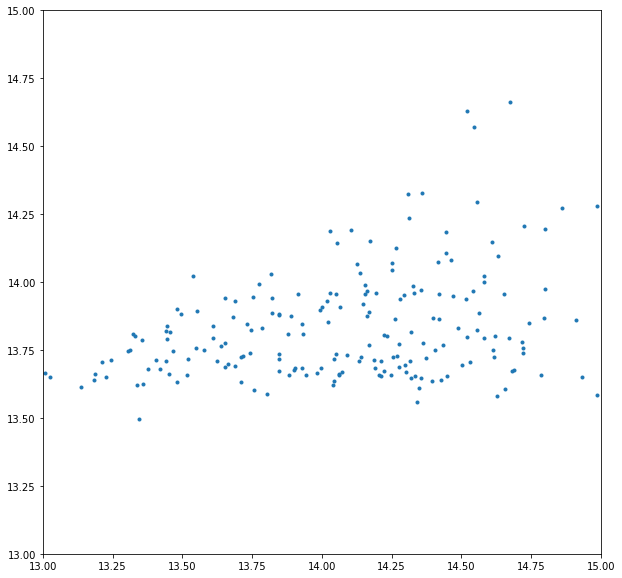

In [27]:
plt.plot(out['logM_vir'],out['logM_2D'],'.')
plt.xlim(13,15)
plt.ylim(13,15)

np.save(os.path.join(wdir, 'data_obs','GAMAspec_GAMAclu','GAMAspec_GAMAclu_'+subfolder+'_preds.npy'),
        out)

In [83]:
out['logM_1D_std']

array([0.06282253, 0.        , 0.03465098, 0.03360208, 0.04950418,
       0.10371772, 0.        , 0.05124923, 0.05330898, 0.08993527,
       0.05672274, 0.06317617, 0.03136624, 0.        , 0.        ,
       0.04207227, 0.03600651, 0.08860468, 0.02901666, 0.07636386,
       0.04314354, 0.07216863, 0.07992739, 0.03613717, 0.04921009,
       0.08140451, 0.02914772, 0.05933369, 0.12511185, 0.03024833,
       0.06623714, 0.05152853, 0.04737621, 0.04271489, 0.04710503,
       0.        , 0.05301557, 0.04066635, 0.05310243, 0.04105156,
       0.0387366 , 0.05479076, 0.        , 0.        , 0.04038066,
       0.05270715, 0.06711929, 0.02869759, 0.08368264, 0.03049948,
       0.07051376, 0.03191863, 0.03352573, 0.        , 0.06742042,
       0.03433686, 0.05930026, 0.02789173, 0.07422668, 0.03427512,
       0.04090385, 0.04570702, 0.        , 0.06305625, 0.03622341,
       0.05260765, 0.        , 0.03913743, 0.04331258, 0.06595346,
       0.17340577, 0.04594875, 0.0439522 , 0.05207115, 0.02814

In [70]:
cl_files = os.listdir(os.path.join(wdir,'data_obs','temp','GAMA'))
cl_files = [i for i in cl_files if i[-4:]=='.csv']

file = cl_files[0]
dat_gama = pd.read_csv(os.path.join(wdir, 'data_obs','temp','GAMA',file))

In [71]:
dat_gama.head()

,DEC,R,RA,VEL,z,GroupID
0,0.40102,3.952492,220.09029,-3669.153602,0.16484,300121
1,0.44999,3.878366,220.11046,-4088.613315,0.16319,300121
2,0.41293,3.623344,220.13617,-3437.815215,0.16575,300121
3,0.17546,3.664397,220.14425,-216.873054,0.17842,300121
4,0.10723,3.674732,220.17033,2559.187593,0.18934,300121


## Coma

In [49]:
dat_cl = pd.read_csv(os.path.join(wdir,'data_obs','GAMAspec_coma','coma_cluster.csv'))

print(dat_cl.columns.values)

dat_cl=dat_cl.rename(index=str,columns={'ra':'RA','dec':'DEC','z':'Z'}) # same format as RedMapper

dat_cl.head()

['ra' 'dec' 'specobjid' 'z']


,RA,DEC,specobjid,Z
0,193.97707,27.734459,7295860639766605824,2.888782
1,193.99803,28.486930,2264256514497734656,0.142809
2,193.99821,28.622316,7296075319411929088,0.511981
3,193.99900,27.955075,2522132678577252352,0.027008
4,194.09395,28.796575,7296086314528206848,0.530268


In [50]:
# Cluster center

cl = np.zeros(shape=(1,),dtype=obj_dtype)

cl['z'] = 0.0231 # wikipedia
cl['ra'] = np.mean(dat_cl['RA'])
cl['dec'] = np.mean(dat_cl['DEC'])

print('z_0:', cl['z'])
print('ra_0:', cl['ra'])
print('dec_0:', cl['dec'])

z_0: [0.0231]
ra_0: [194.87663]
dec_0: [27.924927]


In [51]:
# Galaxy sample

gals = np.zeros(shape=(len(dat_cl),), dtype=obj_dtype)

gals['z'] = dat_cl['Z']
gals['ra'] = dat_cl['RA']
gals['dec'] = dat_cl['DEC']

gals = add_vlos_Rproj(gals, cl)

# gals['vlos'] *= 1.5
# gals['Rproj'] *= 1.5

gals = cylinder_cut(gals, cl)

In [52]:
kdeval_1d = kde_1d(gals)
kdeval_2d = kde_2d(gals)

FOLD 0 ~~ cnn1d: 14.95217 +- 0.14836 	cnn2d: 14.87206 +- 0.09742
FOLD 1 ~~ cnn1d: 14.97393 +- 0.1444 	cnn2d: 14.92563 +- 0.11742
FOLD 2 ~~ cnn1d: 14.99649 +- 0.13061 	cnn2d: 14.92247 +- 0.11535
FOLD 3 ~~ cnn1d: 14.99268 +- 0.14283 	cnn2d: 14.91671 +- 0.10518
FOLD 4 ~~ cnn1d: 14.94769 +- 0.14117 	cnn2d: 14.91547 +- 0.1094
FOLD 5 ~~ cnn1d: 14.9514 +- 0.15667 	cnn2d: 14.96765 +- 0.1172
FOLD 6 ~~ cnn1d: 14.93055 +- 0.1514 	cnn2d: 14.89223 +- 0.1085
FOLD 7 ~~ cnn1d: 14.98775 +- 0.15471 	cnn2d: 14.93838 +- 0.11884
FOLD 8 ~~ cnn1d: 14.94904 +- 0.1494 	cnn2d: 14.90461 +- 0.10707
FOLD 9 ~~ cnn1d: 14.96983 +- 0.13892 	cnn2d: 14.95865 +- 0.11406

AVG ~~ cnn1d: 14.965152444736331 	cnn2d: 14.92138541689967
STD ~~ cnn1d: 0.14603888446463015 	cnn2d: 0.11122884950359965


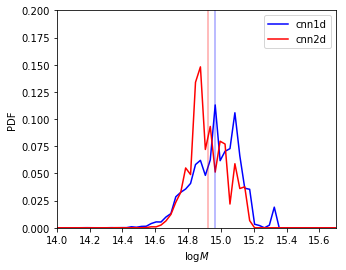

In [57]:
logM_1d = np.zeros(shape=(par_1d['nfolds'],par_1d['nbins']))
logM_2d = np.zeros(shape=(par_2d['nfolds'],par_2d['nbins']))

for i in range(par_1d['nfolds']):
    logM_1d[i,:] = model_1d[i].predict(kdeval_1d)[0]
    logM_2d[i,:] = model_2d[i].predict(kdeval_2d)[0]
    
    pred_1d = np.dot(logM_1d[i,:], bin_centers_1d)
    pred_2d = np.dot(logM_2d[i,:], bin_centers_2d)
    std_1d = np.sqrt(np.dot(logM_1d[i,:], bin_centers_1d**2) - pred_1d**2)
    std_2d = np.sqrt(np.dot(logM_2d[i,:], bin_centers_2d**2) - pred_2d**2)
    
    print('FOLD', i, '~~ cnn1d:', round(pred_1d,5),'+-',round(std_1d,5),
          '\tcnn2d:', round(pred_2d,5),'+-',round(std_2d,5),)
    
print('\nAVG ~~ cnn1d:', np.dot(np.mean(logM_1d, axis=0),bin_centers_1d), 
      '\tcnn2d:', np.dot(np.mean(logM_2d, axis=0),bin_centers_2d))
print('STD ~~ cnn1d:', np.sqrt(np.sum(np.dot(logM_1d,bin_centers_1d**2) - np.dot(logM_1d,bin_centers_1d)**2))/np.sqrt(par_1d['nfolds'])
      , '\tcnn2d:', np.sqrt(np.sum(np.dot(logM_2d,bin_centers_2d**2) - np.dot(logM_2d,bin_centers_2d)**2))/np.sqrt(par_2d['nfolds']))

f = plt.figure(figsize=(5,4))

plt.plot(bin_centers_1d, np.mean(logM_1d,axis=0), label='cnn1d', color='b', alpha=1)#, width=2.5/par_1d['nbins'])
plt.plot(bin_centers_2d, np.mean(logM_2d,axis=0), label='cnn2d', color='r', alpha=1)#, width=2.5/par_2d['nbins'])
plt.axvline(np.dot(np.mean(logM_1d, axis=0),bin_centers_1d), color='b', alpha=0.35)
plt.axvline(np.dot(np.mean(logM_2d, axis=0),bin_centers_2d), color='r', alpha=0.35)

plt.xlabel('$\log M$')
plt.ylabel('PDF')

plt.xlim(14,15.7)
plt.ylim(0,0.2)
plt.legend()

f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=300)

# Preprocessing

## Sample Stats, Cylinder Cut

Text(0,0.5,'dec')

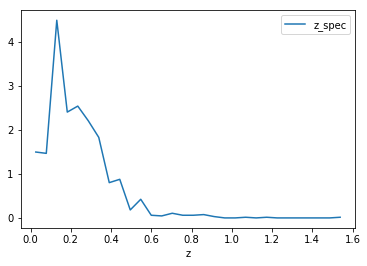

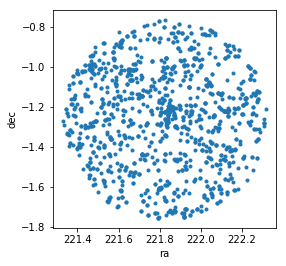

In [81]:
# p(z)



plt.figure()
x,y=plot_hist(dat_cl['Z'],label='z_spec')
plt.xlabel('z')
plt.legend()


# projected plane-of-sky
plt.figure(figsize=(4,4))
plt.plot(dat_cl['RA'],dat_cl['DEC'],'.')
plt.xlabel('ra')
plt.ylabel('dec')

In [82]:
# Calculate Rproj, vlos

c = 299792.458  # [km/s]

gal_vlos = c*(dat_cl['Z'] - cl_z)/(1.0+cl_z) # [km/s]

pos_cl = SkyCoord(ra=cl_ra*units.deg, dec=cl_dec*units.deg)
pos_gal = SkyCoord(ra=dat_cl['RA'].values*units.deg, dec=dat_cl['DEC'].values*units.deg)
gal_Rproj = cosmo.kpc_proper_per_arcmin(cl_z).value * pos_gal.separation(pos_cl).arcmin / cosmo.h # [kpc/h]
gal_Rproj /= 1000. # [Mpc/h]

gal_vlos = gal_vlos.values
# gal_Rproj = gal_Rproj.values

In [83]:
# Cylinder cut

members =(gal_vlos > -vcut) & (gal_vlos < vcut) & (gal_Rproj < aperture)
gal_vlos = gal_vlos[members]
gal_Rproj = gal_Rproj[members]

(-2500.0, 2500.0)

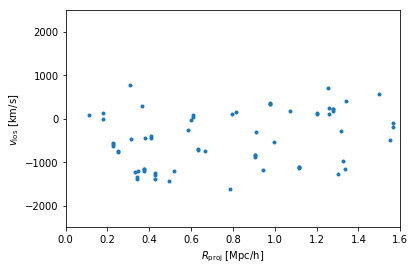

In [84]:
plt.figure()

plt.plot(gal_Rproj, gal_vlos,'.')
plt.xlabel('$R_\mathrm{proj}$ [Mpc/h]')
plt.ylabel('$v_\mathrm{los}$ [km/s]')

plt.xlim(0,aperture)
plt.ylim(-vcut,vcut)

## KDE

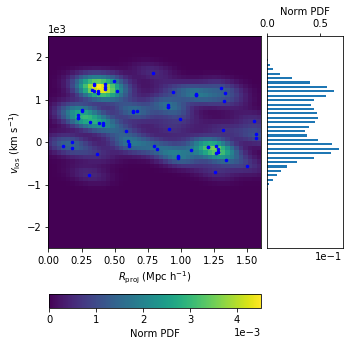

In [85]:
shape=(48,48)


#1D KDE
kde = gaussian_kde(gal_vlos, bw_method=kde_bandwidth)
v_pos = np.linspace(-vcut, vcut, shape[1] + 1)
v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]

kdeval_1d = kde(v_pos)
kdeval_1d = np.flip(kdeval_1d,0)/kdeval_1d.sum()


#2D KDE
a_pos = np.linspace(0, aperture, shape[0] + 1)
a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

mesh = np.meshgrid(a_pos,v_pos)
mesh = np.flip(mesh,0)
sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

memb = np.ndarray(shape=(2,len(gal_vlos)))
memb[0,:] = gal_vlos
memb[1,:] = gal_Rproj

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, kde_bandwidth)

# sample kde at fixed intervals
kdeval_2d = np.reshape(kde(sample), mesh[0].shape)

# normalize input
kdeval_2d /= kdeval_2d.sum()



# plot
f = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2,3, wspace=0.05,hspace=0.4, width_ratios=[1.2,2.8,1],height_ratios=[15,1])


# 2D
ax1 = f.add_subplot(gs[0,0:2])

im =ax1.imshow(kdeval_2d, aspect='auto', interpolation='nearest',
               extent=[0, aperture, -vcut, vcut])


ax1.plot(gal_Rproj, 
         -gal_vlos,
         'b.', markersize=5)

ax1.set_ylim(-vcut, vcut)

ax1.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))
ax1.set_aspect(aspect=aperture/(2*vcut),adjustable='box', anchor='E')
# ax1.set_title('2D KDE', y=1.07)
ax1.set_xlabel('$R_\mathrm{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax1.set_ylabel('$v_\mathrm{los}$ (km s$^{-1}$)', fontsize=10)


# 1D
ax2 = f.add_subplot(gs[0,2])
ax2.barh(v_pos, kdeval_1d, height=50)

ax2.set_ylim(-vcut, vcut)

# ax2.set_title('1D KDE', y=1.07)
ax2.set_xlabel('Norm PDF', fontsize=10)
# ax2.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position('right')
ax2.set_yticks([])

ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')

# Colorbar
ax3 = f.add_subplot(gs[1,1])
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=kdeval_2d.min(), vmax=kdeval_2d.max())

cb = mpl.colorbar.ColorbarBase(label='Norm PDF', ax=ax3, norm=norm, orientation='horizontal')
cb.set_label('Norm PDF',fontsize=10)
cb.formatter.set_powerlimits((0, 1))
cb.update_ticks()



# plt.suptitle('$\log[M_{200c}\ ($M$_\odot h^{-1})] = $' + str(np.log10(cat.prop.loc[i,'M200c']))[0:6], fontsize=14, y=1.05)

# plt.tight_layout()

# f.savefig(os.path.join(imdir,'ex_kde.pdf'),bbox_inches='tight')

In [86]:
gal_Rproj

array([0.34209111, 1.11555182, 0.18075832, 0.6086112 , 0.90338409,
       1.27702716, 1.55290758, 1.56447674, 1.27635014, 0.90527459,
       0.34435185, 0.18051852, 1.11433057, 0.60880274, 1.30432877,
       1.27703347, 1.56500813, 0.90350422, 1.11581034, 0.34183103,
       0.79592612, 0.58715284, 0.49540845, 0.11251688, 0.94142021,
       0.30907062, 0.25230572, 0.31068956, 0.33255313, 0.51682964,
       1.25358855, 0.81691094, 0.22456653, 1.50011899, 1.33835916,
       0.59875968, 0.38002548, 0.3766731 , 1.33395674, 1.32638444,
       0.22456653, 0.3766731 , 0.63504318, 0.22456653, 0.3766731 ,
       0.63504318, 1.07288317, 0.66748004, 0.78618149, 0.36733082,
       1.26036028, 0.41036695, 0.41036695, 0.42889851, 0.97585029,
       1.26036028, 0.25272938, 0.9114728 , 1.20384182, 0.99438259,
       0.42889851, 1.31535813, 0.97585029, 0.97585029, 1.20384182,
       0.42889851])

# Load RedMapper

In [23]:
cl_files = os.listdir(os.path.join(wdir,'data_obs','clusters_arya'))
cl_files = [i for i in cl_files if i[-4:]=='.csv']

print(pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl_files[0])).columns.values)

['SPECID' 'SURVEY' 'SURVEY_CODE' 'RA' 'DEC' 'WMIN' 'WMAX' 'Z' 'NQ' 'PROB'
 'FILENAME' 'URL' 'URL_IMG' 'CATAID' 'GAMA_NAME' 'IC_FLAG' 'DIST'
 'IS_SBEST' 'IS_BEST' 'NAME' 'RA_RM' 'DEC_RM' 'Z_LAMBDA' 'Z_LAMBDA_ERR'
 'LAMBDA' 'LAMBDA_ERR' 'S' 'Z_SPEC' 'OBJID' 'IMAG' 'IMAG_ERR'
 'MODEL_MAG_U' 'MODEL_MAGERR_U' 'MODEL_MAG_G' 'MODEL_MAGERR_G'
 'MODEL_MAG_R' 'MODEL_MAGERR_R' 'MODEL_MAG_I' 'MODEL_MAGERR_I'
 'MODEL_MAG_Z' 'MODEL_MAGERR_Z' 'ILUM' 'ang_sep' 'LOS_vel'
 'proper_distance']


## Duplicates

In [72]:
perc_dupl = []

for cl in cl_files[:10]:
#     print(cl)
    dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl))
    
    perc_dupl.append(np.sum(dat_cl.duplicated(subset=['RA','DEC']))/len(dat_cl))

np.mean(perc_dupl)

0.1647744440397632

In [73]:
cl = np.random.choice(cl_files)
dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl))

# print(dat_cl.columns.values)
# print(len(dat_cl))

# dat_cl[dat_cl.duplicated(subset=['RA','DEC'])].sort_values(['RA','DEC'])
if np.sum(dat_cl.duplicated(subset=['RA','DEC']))>0:
    i = np.random.choice(np.argwhere(dat_cl.duplicated(subset=['RA','DEC']).values).flatten())
    display(dat_cl[np.sum(dat_cl[['RA','DEC']] == dat_cl[['RA','DEC']].iloc[i].values, axis=1)>0])

,SPECID,SURVEY,SURVEY_CODE,RA,DEC,WMIN,WMAX,Z,NQ,PROB,...,MODEL_MAG_R,MODEL_MAGERR_R,MODEL_MAG_I,MODEL_MAGERR_I,MODEL_MAG_Z,MODEL_MAGERR_Z,ILUM,ang_sep,LOS_vel,proper_distance
301,G15_Y4_208_218,GAMA,5,213.42446,2.77143,3726.53,8857.58,0.70723,1,0.16,...,19.802841,0.040077,19.105967,0.033132,18.627953,0.075661,19.243595,0.45279,125199.292663,7982.430089
970,G15_Y6_098_260,GAMA,5,213.42446,2.77143,3727.88,8858.87,0.44282,4,1.00,...,19.802841,0.040077,19.105967,0.033132,18.627953,0.075661,19.243595,0.45279,59378.009770,7982.430089


## Load Single Clusters

In [79]:
cl = np.random.choice(cl_files)
dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl))

dat_cl = dat_cl[dat_cl['Z']>0]

In [80]:
# Cluster center

if len(dat_cl['Z_SPEC'].unique()):
    cl_z = dat_cl['Z_SPEC'].unique()[0]
else:
    raise Exception('multiple cl centers')
    
cl_ra = np.mean(dat_cl['RA'])
cl_dec = np.mean(dat_cl['DEC'])

print('z_0:', cl_z)
print('ra_0:', cl_ra)
print('dec_0:', cl_dec)

z_0: 0.14816378
ra_0: 221.817547015748
dec_0: -1.2548185118110236


# Scratch

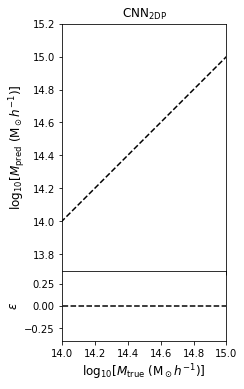

In [9]:
model_name = 'halo_cnn2d_rP'
model_num = 4

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat['params']

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']

f = plt.figure(figsize=[3.5,6])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[4,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(one_to_one,one_to_one, color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_test'], cnn_dat['logmass_pred'], n=20, 
            percentiles=[34,47], median=True, ax=ax1, log=0, c='g'
            )
ax1.set_ylabel(r'$\log_{10}[M_\mathrm{pred}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

ax1.set_xticklabels([])
ax1.set_xlim(xmin=14, xmax=15)
ax1.set_ylim(ymin=13.7, ymax=15.2)
ax1.set_aspect(aspect='equal',adjustable='box', anchor='S')


# pred_err = (10.**cnn_dat['logmass_pred'])/(10.**cnn_dat['logmass_test']) - 1.
pred_err = cnn_dat['logmass_pred'] - cnn_dat['logmass_test']

ax2 = f.add_subplot(gs[1,0])# , sharex=ax1)
ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_test'],pred_err,n=20, percentiles=[34, 47], 
                median=True, ax=ax2, label='cnn',c='g', errorbar=False, names=False, log=0)

ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-0.4,ymax=0.4)
ax2.set_ylabel(r'$\epsilon$',fontsize=12)
ax2.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

# ax2.set_yticklabels([-0.5,0,1])


ax1.set_title('CNN$_\mathrm{2DP}$', fontsize=12)

plt.tight_layout()

# f.savefig(os.path.join(imdir,'pred_1d.pdf'),bbox_inches='tight', dpi=300)

(array([    0.,     0.,     0.,     0.,     0., 74363.,     0.,     0.,
            0.,     0.]),
 array([13.00062084, 13.10062084, 13.20062084, 13.30062084, 13.40062084,
        13.50062084, 13.60062084, 13.70062084, 13.80062084, 13.90062084,
        14.00062084]),
 <a list of 10 Patch objects>)

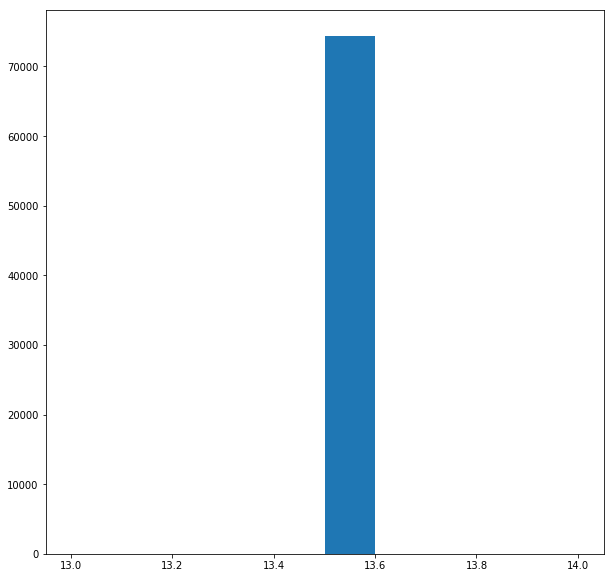

In [11]:
plt.hist(cnn_dat['logmass_pred'])